Project Title "Time Series Forecasting of Hotel Bookings to Optimize Resource Allocation and Pricing Strategies"

Overall Objective Develop a data-driven forecasting model to predict monthly hotel booking demand, incorporating seasonality, trends, and external factors. The project includes preprocessing, feature engineering, model development, evaluation, and business insights.

Null Hypothesis (𝐻0):
There is no significant seasonality in the monthly hotel booking demand. Any observed patterns are due to random fluctuations.

Alternate Hypothesis (𝐻𝐴):
There is significant seasonality in the monthly hotel booking demand, indicating recurring patterns that are not random.

1. Preprocessing

In [ ]:
#Missing values, transformation of date to datetime
import pandas as pd

# Load dataset
df = pd.read_csv('hotel_bookings.csv')

# Handle missing values
df['children'].fillna(0, inplace=True)  # Replace missing 'children' values with 0
df['country'].fillna('Unknown', inplace=True)  # Replace missing 'country' with 'Unknown'

# Transform date column to datetime format
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

# Display initial info
print("Dataset Info:")
print(df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119390 non

<ipython-input-1-50cbf96b5331>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['children'].fillna(0, inplace=True)  # Replace missing 'children' values with 0
<ipython-input-1-50cbf96b5331>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

In [ ]:
# Create a 'year_month' column for monthly aggregation
df['year_month'] = df['reservation_status_date'].dt.to_period('M')

# Aggregate data by month to compute the target variable (demand)
monthly_demand = df.groupby('year_month').size().reset_index(name='demand')

# Convert 'year_month' back to a timestamp for easy handling
monthly_demand['year_month'] = monthly_demand['year_month'].dt.to_timestamp()

# Display the aggregated data
print("Aggregated Monthly Demand:")
print(monthly_demand.head())


Aggregated Monthly Demand:
  year_month  demand
0 2014-10-01     180
1 2014-11-01       1
2 2015-01-01     948
3 2015-02-01      44
4 2015-03-01      85


In [ ]:
# Create lagged demand features (1-month, 2-month, and 3-month lags)
for lag in range(1, 4):
    monthly_demand[f'lag_{lag}'] = monthly_demand['demand'].shift(lag)

# Drop rows with NaN values caused by lagging
monthly_demand = monthly_demand.dropna()

# Display data with lagged features
print("Data with Lagged Variables:")
print(monthly_demand.head())


Data with Lagged Variables:
  year_month  demand  lag_1  lag_2  lag_3
3 2015-02-01      44  948.0    1.0  180.0
4 2015-03-01      85   44.0  948.0    1.0
5 2015-04-01     151   85.0   44.0  948.0
6 2015-05-01     275  151.0   85.0   44.0
7 2015-06-01     666  275.0  151.0   85.0


In [ ]:
# Add a column for the month
monthly_demand['month'] = monthly_demand['year_month'].dt.month

# Add a binary column indicating holiday season (e.g., December, January, July, August)
monthly_demand['is_holiday_season'] = monthly_demand['month'].apply(
    lambda x: 1 if x in [12, 1, 7, 8] else 0
)

# Display the feature-enriched dataset
print("Feature-Rich Dataset:")
print(monthly_demand.head())


Feature-Rich Dataset:
  year_month  demand  lag_1  lag_2  lag_3  month  is_holiday_season
3 2015-02-01      44  948.0    1.0  180.0      2                  0
4 2015-03-01      85   44.0  948.0    1.0      3                  0
5 2015-04-01     151   85.0   44.0  948.0      4                  0
6 2015-05-01     275  151.0   85.0   44.0      5                  0
7 2015-06-01     666  275.0  151.0   85.0      6                  0


In [ ]:
# Save the preprocessed dataset to a CSV file
monthly_demand.to_csv('preprocessed_hotel_demand.csv', index=False)

print("Preprocessed dataset saved as 'preprocessed_hotel_demand.csv'.")


Preprocessed dataset saved as 'preprocessed_hotel_demand.csv'.


2. EDA and Model Building

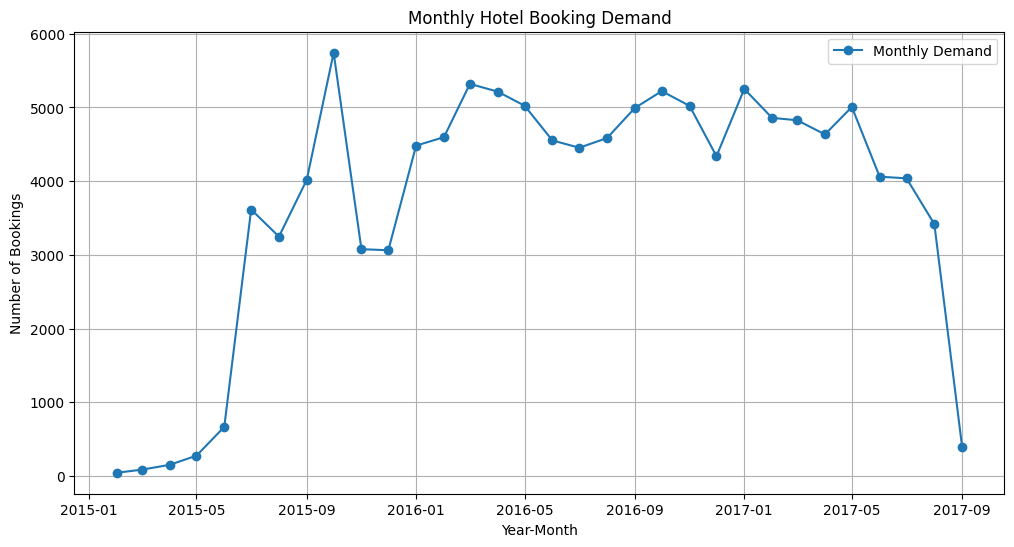

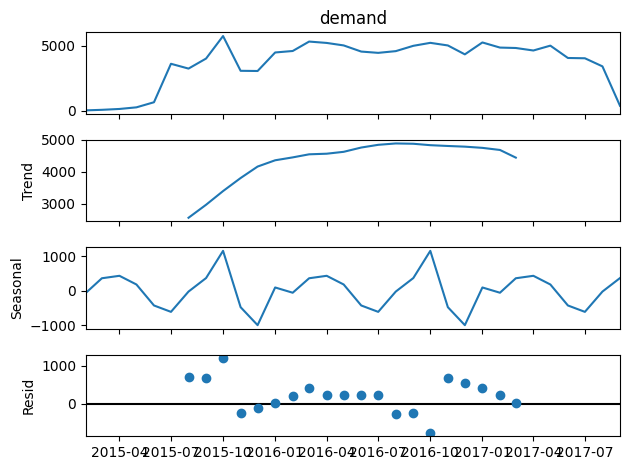

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the preprocessed dataset
monthly_demand = pd.read_csv('preprocessed_hotel_demand.csv', parse_dates=['year_month'], index_col='year_month')

# Plot the demand trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_demand.index, monthly_demand['demand'], marker='o', label='Monthly Demand')
plt.title('Monthly Hotel Booking Demand')
plt.xlabel('Year-Month')
plt.ylabel('Number of Bookings')
plt.legend()
plt.grid(True)
plt.show()

# Decompose the time series into trend, seasonality, and residuals
decomposition = seasonal_decompose(monthly_demand['demand'], model='additive', period=12)
decomposition.plot()
plt.show()


Correlation Matrix:
                     demand     lag_1     lag_2     lag_3     month  \
demand             1.000000  0.819536  0.733354  0.700126  0.078318   
lag_1              0.819536  1.000000  0.871377  0.811588  0.212757   
lag_2              0.733354  0.871377  1.000000  0.886287  0.245450   
lag_3              0.700126  0.811588  0.886287  1.000000  0.074767   
month              0.078318  0.212757  0.245450  0.074767  1.000000   
is_holiday_season  0.134424 -0.009603  0.093689  0.187552  0.177382   

                   is_holiday_season  
demand                      0.134424  
lag_1                      -0.009603  
lag_2                       0.093689  
lag_3                       0.187552  
month                       0.177382  
is_holiday_season           1.000000  


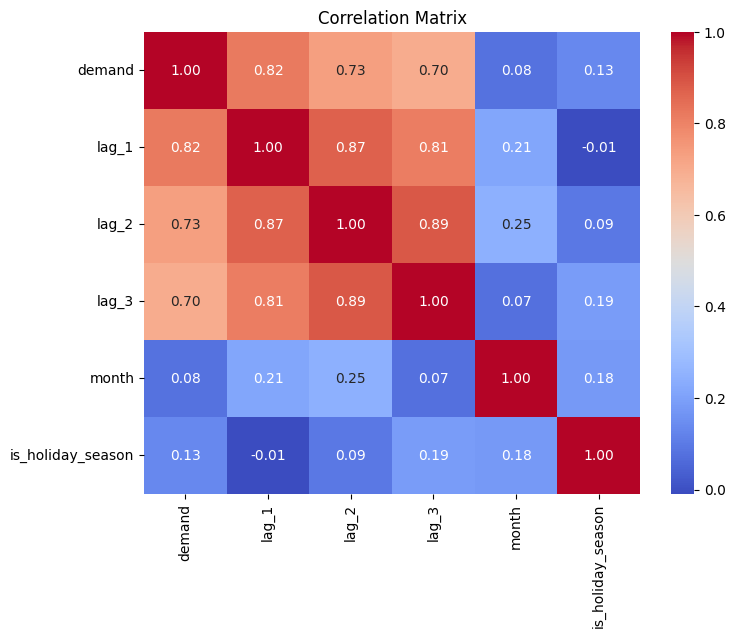

In [ ]:
# Check correlation with lagged variables and seasonal indicators
correlations = monthly_demand.corr()
print("Correlation Matrix:")
print(correlations)

# Visualize the correlation matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
#Building models
# Split the dataset into training and testing sets (80% train, 20% test)
train_size = int(len(monthly_demand) * 0.8)
train, test = monthly_demand[:train_size], monthly_demand[train_size:]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/usr/local/lib/python3.10/dist-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: invalid value encountered in l

                                     SARIMAX Results                                      
Dep. Variable:                             demand   No. Observations:                   25
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Thu, 12 Dec 2024   AIC                             10.000
Time:                                    03:08:37   BIC                                nan
Sample:                                02-01-2015   HQIC                               nan
                                     - 02-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3794         -0        inf      0.000      -0.379      -0.379
ma.L1          0.2315         -0   

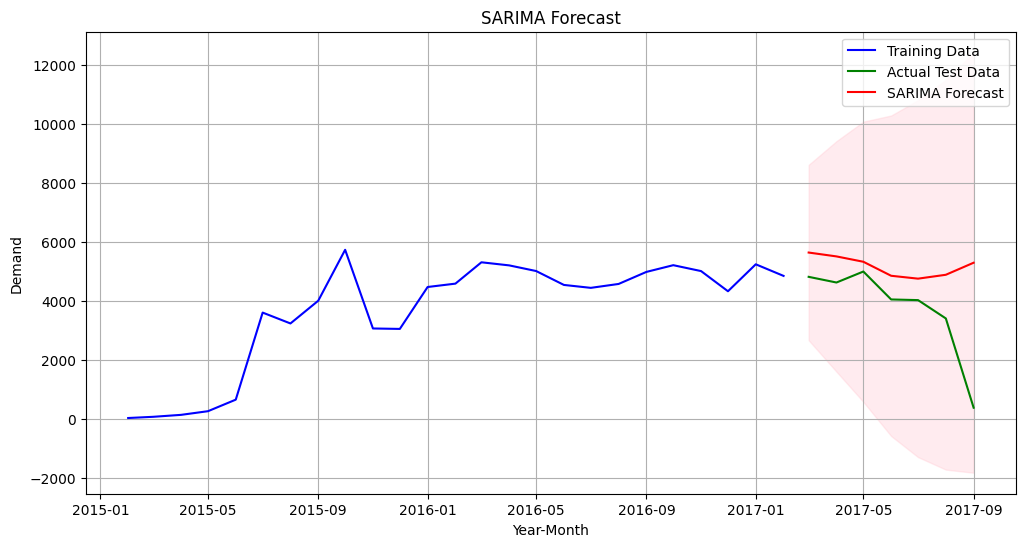

In [ ]:
#Fitting SARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Define the SARIMA model
model = SARIMAX(train['demand'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
sarima_result = model.fit(disp=False)
print(sarima_result.summary())

# Forecast for the test set
forecast = sarima_result.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Evaluate the model
mae = mean_absolute_error(test['demand'], forecast_values)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['demand'], label='Training Data', color='blue')
plt.plot(test.index, test['demand'], label='Actual Test Data', color='green')
plt.plot(test.index, forecast_values, label='SARIMA Forecast', color='red')
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Year-Month')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA Mean Absolute Error (MAE): 1084.29


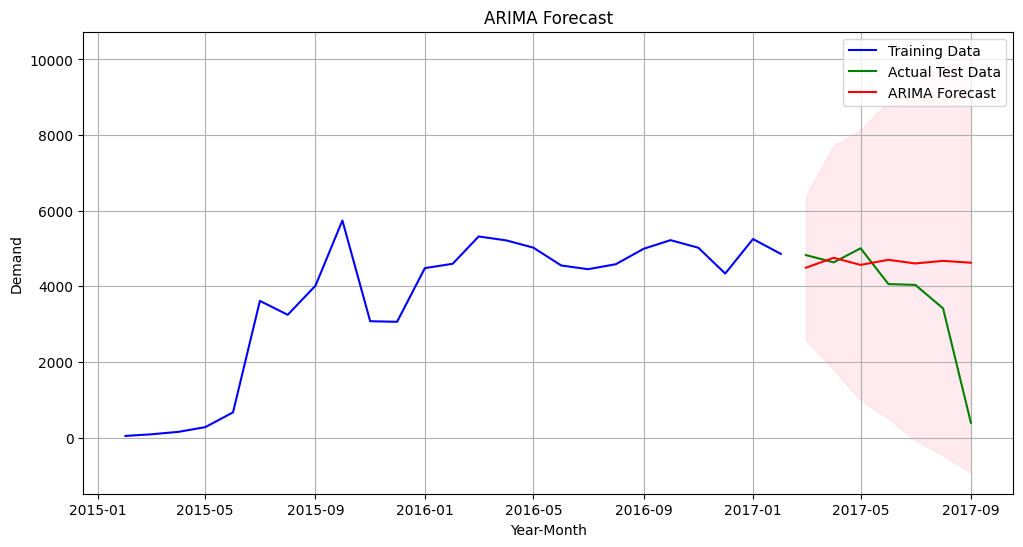

In [ ]:
from statsmodels.tsa.arima.model import ARIMA


# Fit an ARIMA model
arima_model = ARIMA(train['demand'], order=(1, 1, 1))
arima_result = arima_model.fit()

# Forecast for the test set
arima_forecast = arima_result.get_forecast(steps=len(test))
arima_forecast_values = arima_forecast.predicted_mean
arima_forecast_ci = arima_forecast.conf_int()

# Evaluate the ARIMA model
arima_mae = mean_absolute_error(test['demand'], arima_forecast_values)
print(f"ARIMA Mean Absolute Error (MAE): {arima_mae:.2f}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['demand'], label='Training Data', color='blue')
plt.plot(test.index, test['demand'], label='Actual Test Data', color='green')
plt.plot(test.index, arima_forecast_values, label='ARIMA Forecast', color='red')
plt.fill_between(test.index, arima_forecast_ci.iloc[:, 0], arima_forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast')
plt.xlabel('Year-Month')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)
plt.show()



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Holt-Winters Mean Absolute Error (MAE): 2389.29


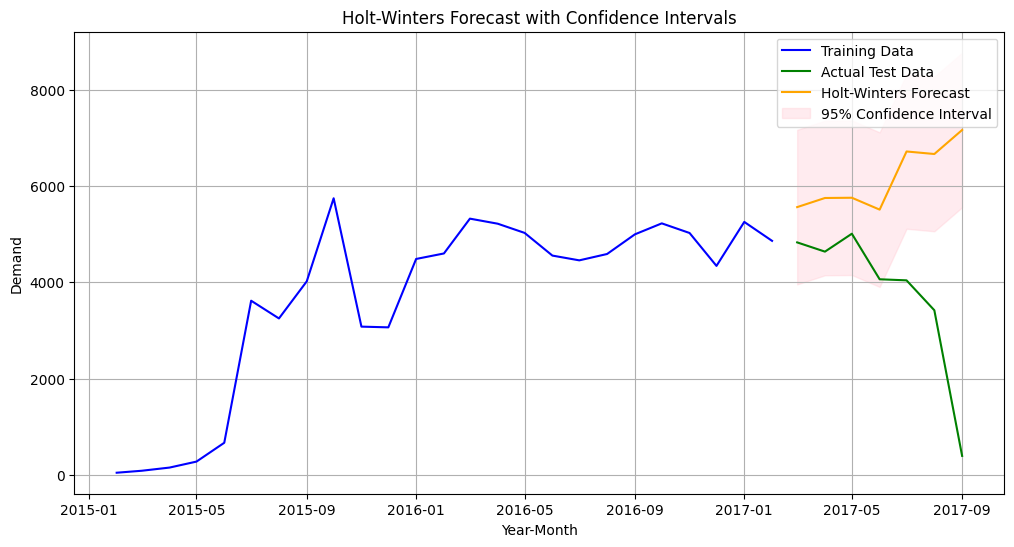

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Fit the Holt-Winters model
hw_model = ExponentialSmoothing(train['demand'], seasonal='add', trend='add', seasonal_periods=12)
hw_result = hw_model.fit()

# Forecast for the test set
hw_forecast = hw_result.forecast(steps=len(test))

# Calculate confidence intervals
# Estimate standard deviation from residuals of the training data
residuals = train['demand'] - hw_result.fittedvalues
forecast_std = np.std(residuals)

# Calculate upper and lower bounds for 95% confidence intervals
ci_upper = hw_forecast + 1.96 * forecast_std
ci_lower = hw_forecast - 1.96 * forecast_std

# Evaluate the Holt-Winters model
hw_mae = mean_absolute_error(test['demand'], hw_forecast)
print(f"Holt-Winters Mean Absolute Error (MAE): {hw_mae:.2f}")

# Plot the results with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['demand'], label='Training Data', color='blue')
plt.plot(test.index, test['demand'], label='Actual Test Data', color='green')
plt.plot(test.index, hw_forecast, label='Holt-Winters Forecast', color='orange')
plt.fill_between(test.index, ci_lower, ci_upper, color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('Holt-Winters Forecast with Confidence Intervals')
plt.xlabel('Year-Month')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Compare MAE values from different models
print("Performance Comparison:")
print(f"SARIMA MAE: {mae:.2f}")
print(f"ARIMA MAE: {arima_mae:.2f}")
print(f"Holt-Winters MAE: {hw_mae:.2f}")


Performance Comparison:
SARIMA MAE: 1422.52
ARIMA MAE: 1084.29
Holt-Winters MAE: 2389.29


Inferential Statistics

In [ ]:
from scipy.stats import ttest_ind

# Separate demand into holiday and non-holiday months
holiday_demand = monthly_demand[monthly_demand['is_holiday_season'] == 1]['demand']
non_holiday_demand = monthly_demand[monthly_demand['is_holiday_season'] == 0]['demand']

# Perform a two-sample t-test
t_stat, p_value = ttest_ind(holiday_demand, non_holiday_demand)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: Demand is significantly higher during holiday months.")
else:
    print("Fail to reject the null hypothesis: No significant difference in demand during holiday months.")


T-statistic: 0.7430129994984086, P-value: 0.46325292806272633
Fail to reject the null hypothesis: No significant difference in demand during holiday months.


In [ ]:
from scipy.stats import f_oneway

# Group demand by each month
grouped = [monthly_demand[monthly_demand['month'] == i]['demand'] for i in range(1, 13)]

# Perform ANOVA
f_stat, p_value = f_oneway(*grouped)
print(f"F-statistic: {f_stat:.4f}, P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject the null hypothesis: Significant seasonality exists.")
else:
    print("Fail to reject the null hypothesis: No significant seasonality.")


F-statistic: 0.2812, P-value: 0.9826
Fail to reject the null hypothesis: No significant seasonality.


In [ ]:
# Residual Diagnostics
def arima_residual_diagnostics(arima_result):
    # Extract residuals
    residuals = arima_result.resid

    # Normality Test
    from scipy import stats
    _, norm_p_value = stats.normaltest(residuals)
    print("\nResidual Normality Test:")
    print(f"Normality p-value: {norm_p_value:.4f}")
    print("Interpretation: " +
          ("Residuals are normally distributed" if norm_p_value > 0.05 else
           "Residuals deviate from normal distribution"))

    # Autocorrelation Test
    from statsmodels.stats.diagnostic import acorr_ljungbox

    # Specify lags for the Ljung-Box test
    # Use a range of lags instead of a single lag
    lags = range(1, 11) # Example: lags 1 to 10
    lb_test = acorr_ljungbox(residuals, lags=lags, return_df=True)

    # Check if lb_test is not empty before accessing index 0
    if not lb_test.empty:
        print("\nLjung-Box Test for Autocorrelation:")
        # Access the p-value for the first lag
        p_value_autocorrelation = lb_test['lb_pvalue'].iloc[0]  # Store for interpretation
        print(f"P-value (Lag 1): {p_value_autocorrelation:.4f}")
        print("Interpretation: " +
              ("No significant autocorrelation" if p_value_autocorrelation > 0.05 else
               "Significant autocorrelation detected"))

        # Interpretation based on autocorrelation p-value
        print("\n# Interpretation")
        if p_value_autocorrelation < 0.05:
            print("Reject the null hypothesis: There is significant autocorrelation in the residuals.")
        else:
            print("Fail to reject the null hypothesis: No significant autocorrelation in the residuals.")

    else:
        print("\nLjung-Box Test for Autocorrelation:")
        print("Test returned an empty result. Consider adjusting the 'lags' parameter or using more data.")

# Run residual diagnostics
arima_residual_diagnostics(arima_result)


Residual Normality Test:
Normality p-value: 0.0437
Interpretation: Residuals deviate from normal distribution

Ljung-Box Test for Autocorrelation:
P-value (Lag 1): 0.1315
Interpretation: No significant autocorrelation

# Interpretation
Fail to reject the null hypothesis: No significant autocorrelation in the residuals.


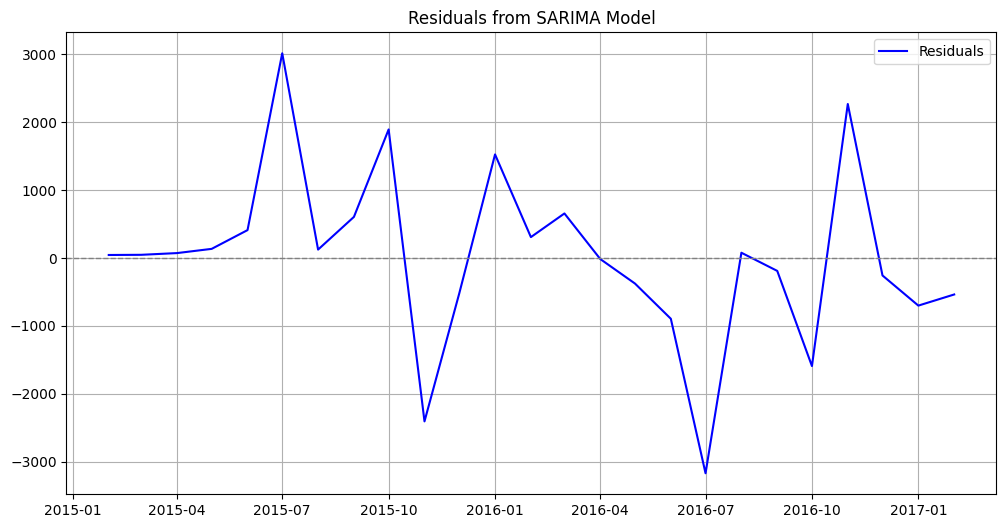


Residual Normality Test:
Normality p-value: 0.3455
Interpretation: Residuals are normally distributed

Ljung-Box Test for Autocorrelation:
      lb_stat  lb_pvalue
1    0.014977   0.902598
2    0.153985   0.925897
3    2.690716   0.441807
4    6.311596   0.177055
5    6.504207   0.260199
6    6.653061   0.354126
7    7.443984   0.384159
8    9.441170   0.306456
9   11.034239   0.273369
10  11.078692   0.351420

P-value (Lag 1): 0.9026
Interpretation: No significant autocorrelation


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import normaltest
import matplotlib.pyplot as plt

def sarima_residual_diagnostics(sarima_result):
    # Extract residuals
    residuals = sarima_result.resid

    # Plot residuals
    plt.figure(figsize=(12, 6))
    plt.plot(residuals, label='Residuals', color='blue')
    plt.axhline(0, linestyle='--', color='gray', linewidth=1)
    plt.title('Residuals from SARIMA Model')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Normality Test
    _, norm_p_value = normaltest(residuals)
    print("\nResidual Normality Test:")
    print(f"Normality p-value: {norm_p_value:.4f}")
    print("Interpretation: " +
          ("Residuals are normally distributed" if norm_p_value > 0.05 else
           "Residuals deviate from normal distribution"))

    # Autocorrelation Test (Ljung-Box Test)
    lags = range(1, 11)  # Test for lags 1 to 10
    lb_test = acorr_ljungbox(residuals, lags=lags, return_df=True)
    print("\nLjung-Box Test for Autocorrelation:")
    print(lb_test)

    # Check first lag for interpretation
    p_value_autocorrelation = lb_test['lb_pvalue'].iloc[0]
    print(f"\nP-value (Lag 1): {p_value_autocorrelation:.4f}")
    print("Interpretation: " +
          ("No significant autocorrelation" if p_value_autocorrelation > 0.05 else
           "Significant autocorrelation detected"))

# Run residual diagnostics for the SARIMA model
sarima_residual_diagnostics(sarima_result)
